# Correlation between PAR and lifespan
This notebook contains code for analyzing the associations between mortality (i.e. deceased SardiNIA participants) and their PAR values.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import pearsonr
import random
from scipy.stats import ttest_ind, ttest_1samp

### Mean W1 PAR of deceased participants

Mean decesaed W1 PAR = 0.9540683285646263


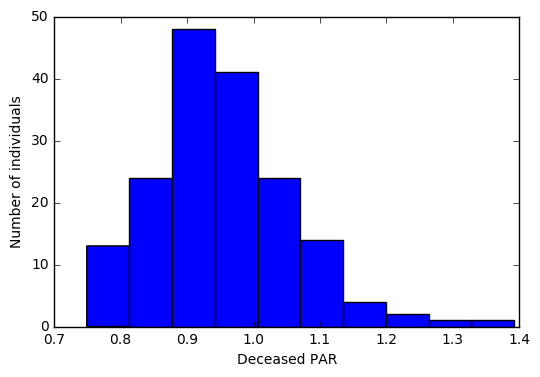

In [8]:
# Read in PAR from file
data = np.genfromtxt('./Results/SardiNIA/wave1_normal_rf.tsv', delimiter='\t')
ids = data[:,0]
chron = data[:,1]
pred = data[:,2]
PAR = pred/chron

# Read in deceased id's from file
deaths = np.genfromtxt('./deceduti_Deaths 2001-2017.csv', delimiter=',')
dec_ids = deaths[:,0]

dec_PAR = []

for i in range(len(ids)):
    if ids[i] in dec_ids:
        dec_PAR.append(PAR[i])
        
print ('Mean decesaed W1 PAR = ' + str(np.mean(dec_PAR)))
pl.hist(dec_PAR)
pl.xlabel('Deceased PAR')
pl.ylabel('Number of individuals')
pl.show()

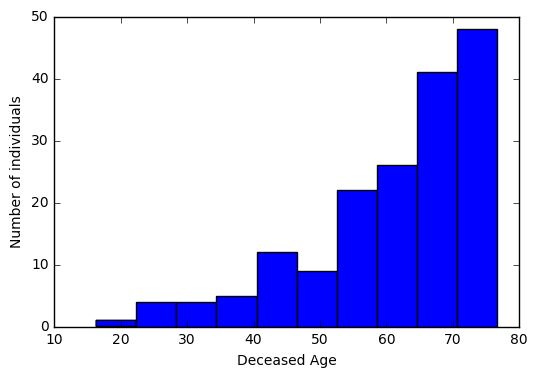

In [17]:
pl.hist(dec_LS)
pl.xlabel('Deceased Age')
pl.ylabel('Number of individuals')
pl.show()

### Preliminary: Assuming W1 age = lifespan, Correlation to lifespan

R2 = 0.3023128217949735


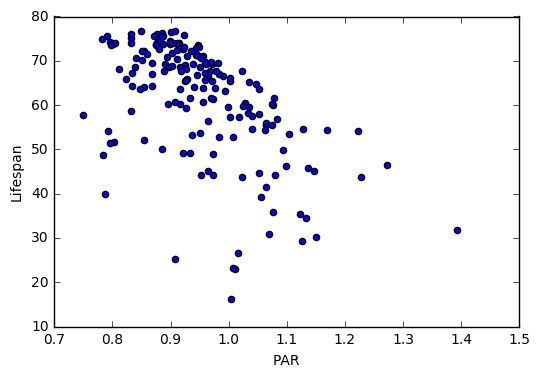

In [16]:
# Read in PAR from file
data = np.genfromtxt('./Results/SardiNIA/wave1_normal_rf.tsv', delimiter='\t')
ids = data[:,0]
chron = data[:,1]
pred = data[:,2]
PAR = pred/chron

# Read in deceased id's from file
deaths = np.genfromtxt('./deceduti_Deaths 2001-2017.csv', delimiter=',')
dec_ids = deaths[:,0]

dec_PAR = []
dec_LS = []

for i in range(len(ids)):
    if ids[i] in dec_ids:
        dec_PAR.append(PAR[i])
        dec_LS.append(chron[i])
        
pearson, p = pearsonr(dec_PAR, dec_LS)
print ('R2 = ' + str(pearson**2))
pl.scatter(dec_PAR, dec_LS)
pl.xlabel('PAR')
pl.ylabel('Lifespan')
pl.show()

There is some correlation, but this could just be the edge effect since R2~0.3 between chronological age and PAR. We would like to see something that is much bigger than 0.3.

## Random age-matched partner t-test

Each deceased subject is randomly age-matched with an individual of the same age from the living subjects group. We then perform a one-tailed, one-sample t-test on the differences in PARs for each pair (e.g. $\Delta $PAR$=$PAR$_{\text{deceased}}-$PAR$_{\text{living}}$.)

In [16]:
def RandomPartner (results_path='./Results/SardiNIA/wave1_normal_rf.tsv', deceased_path='./deceduti_Deaths 2001-2017.csv', N=100):
    # Read in PAR from file
    data = np.genfromtxt(results_path, delimiter='\t')
    ids = data[:,0]
    chron = data[:,1]
    pred = data[:,2]
    PAR = pred/chron

    # Read in deceased id's from file
    deaths = np.genfromtxt(deceased_path, delimiter=',')
    dec_ids = deaths[:,0]

    # Get deceased ages and PARs
    dec_PAR = []
    dec_age = []
    
    for i in range(len(ids)):
        if ids[i] in dec_ids:
            dec_PAR.append(PAR[i])
            dec_age.append(chron[i])
            
    print ('Number of deceased: '+str(len(dec_ids)))
    print ('Age range of deceased: '+str(np.min(dec_age))+'-'+str(np.max(dec_age)))
    
    # Run random age-matched partner t-test
    delta_PAR = []
    p_vals = []
    
    for n in range(N):
        # Get control age-matched partners
        partner_PAR = []
        new_dec_PAR = []
        
        for i, age in enumerate(dec_age):
            matched_idxs = np.where((chron >= age-0.5) & (chron <=age+0.5))[0] 
            rand_idx = random.choice(matched_idxs)
            cnt = 0
            while ids[rand_idx] in dec_ids and cnt<5: # continue drawing if partner is also deceased
                rand_idx = random.choice(matched_idxs)
                cnt += 1
            if cnt == 5:
                continue
            partner_PAR.append(PAR[rand_idx])
            new_dec_PAR.append(dec_PAR[i])

        # Perform two sample t-test on means
        d_par = np.mean(new_dec_PAR)-np.mean(partner_PAR)
        #t, p = ttest_ind(new_dec_PAR, partner_PAR) # two-sample
        t, p = ttest_1samp(np.array(new_dec_PAR)-np.array(partner_PAR), 0, nan_policy='omit') # two-tailed one-sample
        if t > 0: # get one-tailed
            p = p/2
        else:
            p = 1-p/2
        
        if len(new_dec_PAR)!=len(partner_PAR):
            raise Exception('Living and deceased group sizes do not match!')
        
        delta_PAR.append(d_par)
        p_vals.append(p)
    
    return (delta_PAR, p_vals)

In [17]:
delt_pars, pvals = RandomPartner(N=10000)

Number of deceased: 404
Age range of deceased: 16.3-76.7


Fraction p<0.05 = 0.2873
Mean Delta PAR = 0.011845276084277961
Fraction Delta PAR < 0 = 0.0379


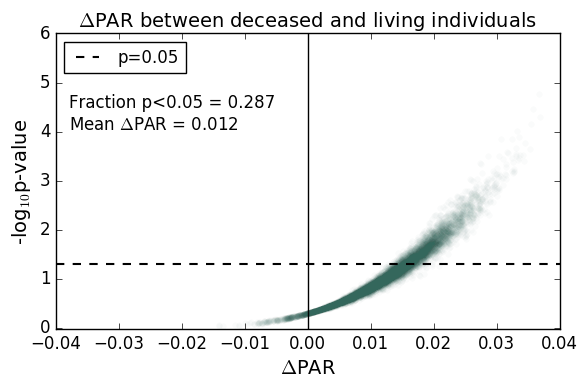

In [18]:
sig_count = 0
for p in pvals:
    if p < 0.05:
        sig_count += 1
        
neg_count = 0
for delt in delt_pars:
    if delt < 0:
        neg_count += 1
        
print ('Fraction p<0.05 = ' + str(sig_count/len(pvals)))
print ('Mean Delta PAR = ' + str(np.mean(delt_pars)))
print ('Fraction Delta PAR < 0 = ' +str(neg_count/len(delt_pars)))

#pl.scatter(-np.log2(delt_pars), -np.log10(pvals),alpha=0.02)
pl.title('$\Delta$'+'PAR between deceased and living individuals', fontsize=14)
pl.scatter(delt_pars, -np.log10(pvals),edgecolor='#34675C',color='#34675C',linewidth=0.0,alpha=0.025)
pl.axhline(y=-np.log10(0.05), xmin=0, xmax=1.0, linewidth=1.5, color='k', linestyle='--', label='p=0.05')
pl.axvline(x=0, ymin=0, ymax=1.0, linewidth=1.0, color = 'k')
#pl.xlabel('-log'+'$_{2}\Delta$' + 'PAR', fontsize=14)
pl.xlim(-0.04, 0.04)
pl.ylim(-0.01, None)
pl.xlabel('$\Delta$' + 'PAR', fontsize=14)
pl.ylabel('-log'+'$_{10}$'+'p-value', fontsize=14)
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.annotate('Fraction p<0.05 = ' + str("%.3f" %(sig_count/len(pvals))), xy=(0.025, 0.75), xycoords='axes fraction', fontsize=12)
pl.annotate('Mean '+'$\Delta$'+'PAR = ' + str("%.3f" %(np.mean(delt_pars))), xy=(0.025, 0.675), xycoords='axes fraction', fontsize=12)
pl.legend(loc='upper left', fontsize=12)
pl.tight_layout()
pl.savefig('./Figures/mortality.png', dpi=800)
pl.show()

# Randomized control

A randomized control pairing where two age-matched subjects are chosen and split into two groups of the same size as the deceased population but without regard for the living statuses of the age-matched partners.

In [19]:
def RandomControl (results_path='./Results/SardiNIA/wave1_normal_rf.tsv', deceased_path='./deceduti_Deaths 2001-2017.csv', N=100):
    # Read in PAR from file
    data = np.genfromtxt(results_path, delimiter='\t')
    ids = data[:,0]
    chron = data[:,1]
    pred = data[:,2]
    PAR = pred/chron

    # Read in deceased id's from file
    deaths = np.genfromtxt(deceased_path, delimiter=',')
    dec_ids = deaths[:,0]

    # Get deceased ages and PARs
    dec_PAR = []
    dec_age = []
    
    for i in range(len(ids)):
        if ids[i] in dec_ids:
            dec_PAR.append(PAR[i])
            dec_age.append(chron[i])
    
    # Run random age-matched partner t-test
    delta_PAR = []
    p_vals = []
    
    for n in range(N):
        # Get two control age-matched partners
        partner1_PAR = []
        partner2_PAR = []
        for age in dec_age:
            matched_idxs = np.where((chron >= age-0.5) & (chron <=age+0.5))[0] 
            rand_idxs = [random.choice(matched_idxs)]
            cnt = 0
            while cnt<5 and len(rand_idxs)<2:
                rand_idx = random.choice(matched_idxs)
                if rand_idx not in rand_idxs:
                    rand_idxs.append(rand_idx)
                cnt += 1
            if len(rand_idxs) < 2 or cnt==5:
                continue
            partner1_PAR.append(PAR[rand_idxs[0]])
            partner2_PAR.append(PAR[rand_idxs[1]])

        # Perform two sample t-test on means
        d_par = np.mean(partner1_PAR)-np.mean(partner2_PAR)
        #t, p = ttest_ind(partner1_PAR, partner2_PAR)
        t, p = ttest_1samp(np.array(partner1_PAR)-np.array(partner2_PAR), 0, nan_policy='omit') # two-tailed one-sample 
        if t > 0: # get one-tailed
            p = p/2
        else:
            p = 1-p/2
            
        if len(partner1_PAR)!=len(partner2_PAR):
            raise Exception('Living and deceased group sizes do not match!')
        
        delta_PAR.append(d_par)
        p_vals.append(p)
    
    return (delta_PAR, p_vals)

In [21]:
delt_pars, pvals = RandomControl(N=10000)

Fraction p<0.05 = 0.0509
Mean Delta PAR = 2.3767960587030425e-05
Fraction Delta PAR < 0 = 0.4954


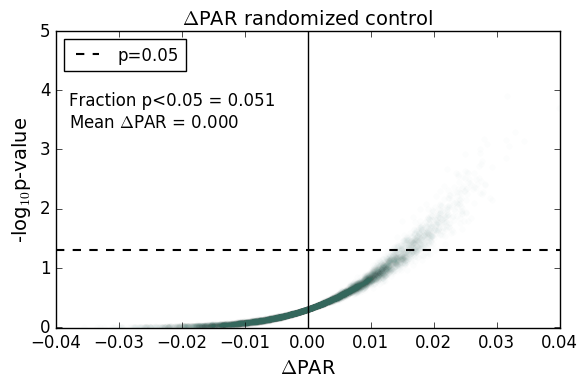

In [22]:
sig_count = 0
for p in pvals:
    if p < 0.05:
        sig_count += 1

        neg_count = 0
for delt in delt_pars:
    if delt < 0:
        neg_count += 1
        
print ('Fraction p<0.05 = ' + str(sig_count/len(pvals)))
print ('Mean Delta PAR = ' + str(np.mean(delt_pars)))
print ('Fraction Delta PAR < 0 = ' +str(neg_count/len(delt_pars)))

#pl.scatter(-np.log2(delt_pars), -np.log10(pvals),alpha=0.02)
pl.title('$\Delta$'+'PAR randomized control', fontsize=14)
pl.scatter(delt_pars, -np.log10(pvals),edgecolor='#34675C',color='#34675C',linewidth=0.0,alpha=0.01)
pl.axhline(y=-np.log10(0.05), xmin=0, xmax=1.0, linewidth=1.5, color='k', linestyle='--', label='p=0.05')
pl.axvline(x=0, ymin=0, ymax=1.0, linewidth=1.0, color = 'k')
#pl.xlabel('-log'+'$_{2}\Delta$' + 'PAR', fontsize=14)
pl.xlim(-0.04, 0.04)
pl.ylim(-0.01, None)
pl.xlabel('$\Delta$' + 'PAR', fontsize=14)
pl.ylabel('-log'+'$_{10}$'+'p-value', fontsize=14)
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.annotate('Fraction p<0.05 = ' + str("%.3f" %(sig_count/len(pvals))), xy=(0.025, 0.75), xycoords='axes fraction', fontsize=12)
pl.annotate('Mean '+'$\Delta$'+'PAR = ' + str("%.3f" %(np.mean(delt_pars))), xy=(0.025, 0.675), xycoords='axes fraction', fontsize=12)
pl.legend(loc='upper left', fontsize=12)
pl.tight_layout()
pl.savefig('./Figures/mortality_control.png', dpi=800)
pl.show()

# Results for 65-trait model

Number of deceased: 404
Age range of deceased: 16.3-76.9
Fraction p<0.05 = 0.1517
Mean Delta PAR = 0.008264105627138469
Fraction Delta PAR < 0 = 0.0852


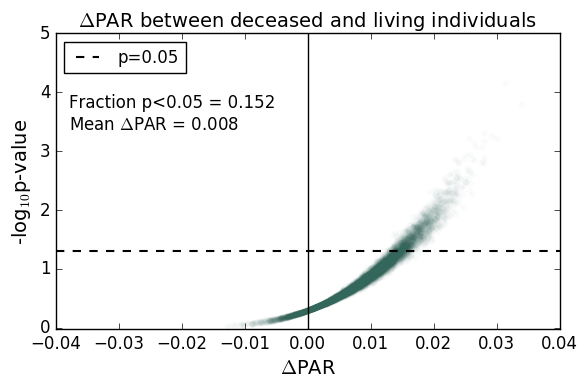

In [23]:
delt_pars, pvals = RandomPartner (results_path='./Results/SardiNIA/wave1_common_rf.tsv', deceased_path='./deceduti_Deaths 2001-2017.csv', N=10000)

sig_count = 0
for p in pvals:
    if p < 0.05:
        sig_count += 1
        
neg_count = 0
for delt in delt_pars:
    if delt < 0:
        neg_count += 1
        
print ('Fraction p<0.05 = ' + str(sig_count/len(pvals)))
print ('Mean Delta PAR = ' + str(np.mean(delt_pars)))
print ('Fraction Delta PAR < 0 = ' +str(neg_count/len(delt_pars)))

#pl.scatter(-np.log2(delt_pars), -np.log10(pvals),alpha=0.02)
pl.title('$\Delta$'+'PAR between deceased and living individuals', fontsize=14)
pl.scatter(delt_pars, -np.log10(pvals),edgecolor='#34675C',color='#34675C',linewidth=0.0,alpha=0.025)
pl.axhline(y=-np.log10(0.05), xmin=0, xmax=1.0, linewidth=1.5, color='k', linestyle='--', label='p=0.05')
pl.axvline(x=0, ymin=0, ymax=1.0, linewidth=1.0, color = 'k')
#pl.xlabel('-log'+'$_{2}\Delta$' + 'PAR', fontsize=14)
pl.xlim(-0.04, 0.04)
pl.ylim(-0.01, None)
pl.xlabel('$\Delta$' + 'PAR', fontsize=14)
pl.ylabel('-log'+'$_{10}$'+'p-value', fontsize=14)
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.annotate('Fraction p<0.05 = ' + str("%.3f" %(sig_count/len(pvals))), xy=(0.025, 0.75), xycoords='axes fraction', fontsize=12)
pl.annotate('Mean '+'$\Delta$'+'PAR = ' + str("%.3f" %(np.mean(delt_pars))), xy=(0.025, 0.675), xycoords='axes fraction', fontsize=12)
pl.legend(loc='upper left', fontsize=12)
pl.tight_layout()
pl.savefig('./Figures/mortality_65.png', dpi=800)
pl.show()